### Class 11

###### 1. Graphical representation of Market Swap rates
###### 2. Build interpolation function and create interpolated swap rates 
###### 3.  Graphical representation of the term structure - Discount factors and Yields
###### 4. Nelson-Siegel model
###### 5. Svensson model
###### 6. Pricing of coupon bond using the calibrated Nelson-Siegel model and Svensson model

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import scipy.linalg as sp
from scipy.optimize import minimize 

### 1. Graphical representation of Market Swap rates

In [2]:
# read excel file with Interes rates - GOV
IR_gov = pd.read_excel('IR_SWAP_&_GOV.xlsx', sheet_name="GOV")
IR_gov.head()

,Date,Description,Maturity,Rate
0,2013-06-14,EUR IRG 1 M,0.083333,0.121
1,2013-06-14,EUR IRG 2 M,0.166667,0.167
2,2013-06-14,EUR IRG 3 M,0.250000,0.209
3,2013-06-14,EUR IRG 4 M,0.333333,0.246
4,2013-06-14,EUR IRG 5 M,0.416667,0.280


In [3]:
# read excel file with Interes rates - SWAP
IR_swap = pd.read_excel('IR_SWAP_&_GOV.xlsx', sheet_name="SWAP")
IR_swap.head()

,Date,Description,Maturity,Rate
0,2013-06-14,EURIBOR 1 W,0.020833,0.090
1,2013-06-14,EURIBOR 1 M,0.083333,0.121
2,2013-06-14,EURIBOR 3 M,0.250000,0.209
3,2013-06-14,EURIBOR 6 M,0.500000,0.319
4,2013-06-14,EUR IRS 9 M,0.750000,0.415


In [4]:
# Divide the 'Rate' column by 100 to convert from percentage
y = IR_swap['Rate'] / 100

# Convert the Pandas Series 'y' to a NumPy array
y = y.values

# Print the NumPy array
print(y)

[0.0009   0.00121  0.00209  0.00319  0.00415  0.00504  0.005005 0.00664
 0.00846  0.01034  0.012145 0.013825 0.01536  0.01677  0.018035 0.020125
 0.022257 0.0237   0.0241   0.0242  ]


In [5]:
# Manually build the vector of time-to-maturities using the 30/360-day convention

# Short maturities (in years) for periods less than 1 year
ttmShort = np.array([7, 30, 90, 180, 270]) / 360

# Long maturities (in years) for periods of 1 year or more
ttmLong = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 20, 25, 30])

# Concatenate short and long maturities into a single array
ttm = np.concatenate([ttmShort, ttmLong])

# Print the final array of time-to-maturities
print(ttm)

[1.94444444e-02 8.33333333e-02 2.50000000e-01 5.00000000e-01
 7.50000000e-01 1.00000000e+00 2.00000000e+00 3.00000000e+00
 4.00000000e+00 5.00000000e+00 6.00000000e+00 7.00000000e+00
 8.00000000e+00 9.00000000e+00 1.00000000e+01 1.20000000e+01
 1.50000000e+01 2.00000000e+01 2.50000000e+01 3.00000000e+01]


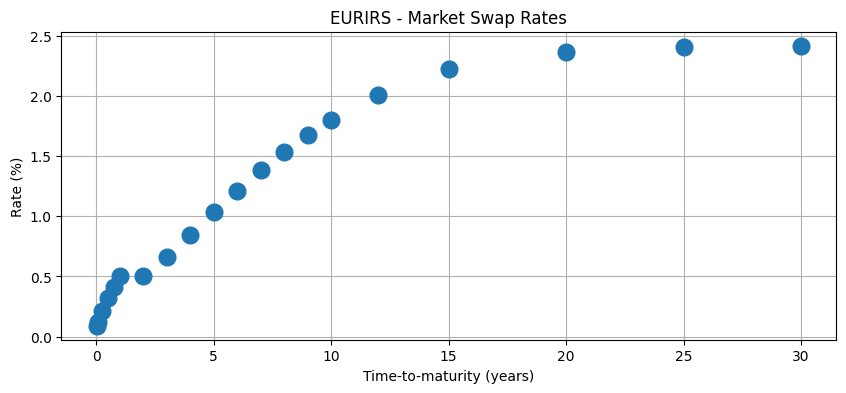

In [48]:
# Plot the market swap rates
plt.figure(figsize=(10, 4))  # Create a figure with specified size
plt.plot(ttm, y * 100, 'o', markersize=12)  # Plot 'y' (rates) against 'ttm' (time-to-maturity)

# Add title and axis labels
plt.title('EURIRS - Market Swap Rates')
plt.xlabel('Time-to-maturity (years)')
plt.ylabel('Rate (%)')
plt.grid()
plt.show()

### 2. Build interpolation function and create interpolated swap rates 

In [6]:
# Build the interpolation function using linear interpolation to estimate swap rates at intermediete maturities
f = interp1d(ttm, y, fill_value="extrapolate")
print(f)
print(type(f))

# Define the time of the first and last coupon payment (in years)
firstTime = 0.5  # First coupon payment after 0.5 years (semi-annual)
lastTime = 30    # Last coupon payment after 30 years

# Define the interval between coupon payments (in years)
delta = 0.5  # Semi-annual interval

# Create a vector of coupon payment times using np.arange (similar to linspace)
k = np.arange(firstTime, lastTime + delta, delta)

# Print the vector of coupon payment times
print(k)

<class 'scipy.interpolate._interpolate.interp1d'>
[ 0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5  7.
  7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5 14.
 14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5 21.
 21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5 28.
 28.5 29.  29.5 30. ]


In [7]:
# Calculate the number of coupon payments
n = len(k)   
print("Number of semi-annual coupon payments:", n)

# Apply the interpolation function to obtain the interpolated swap rates
p = f(k)

# Print the interpolated swap rates
print(p)

# Example interpolated values (for reference):
# 0.00319 --> original 6 months
# 0.00504 --> original 1 year
# 0.0050225 --> interpolated 1.5 years
# 0.005005 --> original 2 years
# 0.0058225 --> interpolated 2.5 years

Number of semi-annual coupon payments: 60
[0.00319    0.00504    0.0050225  0.005005   0.0058225  0.00664
 0.00755    0.00846    0.0094     0.01034    0.0112425  0.012145
 0.012985   0.013825   0.0145925  0.01536    0.016065   0.01677
 0.0174025  0.018035   0.0185575  0.01908    0.0196025  0.020125
 0.02048033 0.02083567 0.021191   0.02154633 0.02190167 0.022257
 0.0224013  0.0225456  0.0226899  0.0228342  0.0229785  0.0231228
 0.0232671  0.0234114  0.0235557  0.0237     0.02374    0.02378
 0.02382    0.02386    0.0239     0.02394    0.02398    0.02402
 0.02406    0.0241     0.02411    0.02412    0.02413    0.02414
 0.02415    0.02416    0.02417    0.02418    0.02419    0.0242    ]


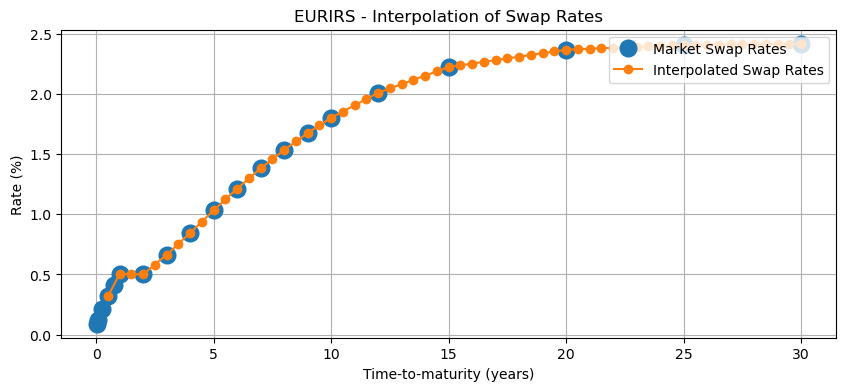

In [8]:
# Graphical representation of market swap rates and interpolated swap rates

# Create a figure for the plot
plt.figure(figsize=(10, 4))

# Plot the market swap rates (original data)
plt.plot(ttm, y * 100, 'o', markersize=12, label='Market Swap Rates')

# Plot the interpolated swap rates (calculated data)
plt.plot(k, p * 100, '-o', label='Interpolated Swap Rates')

# Add legend in the upper right corner
plt.legend(loc='upper right')

# Add title and axis labels
plt.title('EURIRS - Interpolation of Swap Rates')
plt.xlabel('Time-to-maturity (years)')
plt.ylabel('Rate (%)')
plt.grid()
plt.show()

In [9]:
# Since swap rates are annual, but we consider semi-annual (every 6 months) payments, we have to multiply p by delta

converted_p = p*delta
print(converted_p)#

[0.001595   0.00252    0.00251125 0.0025025  0.00291125 0.00332
 0.003775   0.00423    0.0047     0.00517    0.00562125 0.0060725
 0.0064925  0.0069125  0.00729625 0.00768    0.0080325  0.008385
 0.00870125 0.0090175  0.00927875 0.00954    0.00980125 0.0100625
 0.01024017 0.01041783 0.0105955  0.01077317 0.01095083 0.0111285
 0.01120065 0.0112728  0.01134495 0.0114171  0.01148925 0.0115614
 0.01163355 0.0117057  0.01177785 0.01185    0.01187    0.01189
 0.01191    0.01193    0.01195    0.01197    0.01199    0.01201
 0.01203    0.01205    0.012055   0.01206    0.012065   0.01207
 0.012075   0.01208    0.012085   0.01209    0.012095   0.0121    ]


### 3.  Graphical representation of the term structure - Discount factors and Yields

In [15]:
# Bootstrapping from Euribor/Eurirs interest rates to build the yield curve:
# Bootstrapping is an iterative method used to derive the zero-coupon yield curve 
# from market interest rates (Euribor for short-term maturities, Eurirs for long-term maturities). 
# The process starts with the shortest maturities and sequentially solves for spot rates, 
# ensuring consistency with the observed market rates. The resulting yield curve can be used for 
# discounting cash flows and pricing financial instruments.

# We proceed more simply by constructing matrix X (from slide 18) and then solving a linear system

# Create a diagonal matrix with 'converted_p + 1' on the diagonal
X = np.diag(converted_p + 1)

# Fill the off-diagonal entries (column by column)
for i in range(n):
    # For each column 'i', assign the values 'converted_p[i+1:n]' to the elements below the diagonal
    # This fills the sub-diagonal part of the matrix, leaving the diagonal and upper part unchanged
    X[i + 1:n, i] = converted_p[i + 1:n]

# Print the resulting matrix
print(X)

[[1.001595   0.         0.         ... 0.         0.         0.        ]
 [0.00252    1.00252    0.         ... 0.         0.         0.        ]
 [0.00251125 0.00251125 1.00251125 ... 0.         0.         0.        ]
 ...
 [0.01209    0.01209    0.01209    ... 1.01209    0.         0.        ]
 [0.012095   0.012095   0.012095   ... 0.012095   1.012095   0.        ]
 [0.0121     0.0121     0.0121     ... 0.0121     0.0121     1.0121    ]]


In [14]:
# Solve the linear system in slide 18 to obtain the discount factors
V = np.ones(n)
V.shape = (n,1)

# Discount factors: solve the linear system X * v = V to find the discount factors 'v'
v = sp.solve(X,V) 


# The discount factors 'v' represent the present value of a payment of 1 unit at different future times.
# They are used to discount (or adjust) future cash flows to their present value based on the interpolated interest rates.
print(v) 

[[0.99840754]
 [0.99497667]
 [0.99250169]
 [0.99005022]
 [0.98555586]
 [0.98027334]
 [0.97389339]
 [0.9666578 ]
 [0.9584484 ]
 [0.94938493]
 [0.93968492]
 [0.92920051]
 [0.91834138]
 [0.90679069]
 [0.89508538]
 [0.88278753]
 [0.87041604]
 [0.85753889]
 [0.84481486]
 [0.83167497]
 [0.81919723]
 [0.80641341]
 [0.79333641]
 [0.7799793 ]
 [0.76822776]
 [0.75632723]
 [0.74428553]
 [0.73211053]
 [0.71981009]
 [0.70739207]
 [0.69768051]
 [0.68797766]
 [0.67828549]
 [0.66860595]
 [0.65894098]
 [0.64929247]
 [0.63966231]
 [0.63005233]
 [0.62046436]
 [0.61090019]
 [0.60308487]
 [0.59533753]
 [0.58765785]
 [0.58004548]
 [0.57250007]
 [0.56502129]
 [0.55760877]
 [0.55026219]
 [0.54298119]
 [0.53576542]
 [0.52919336]
 [0.52269439]
 [0.51626774]
 [0.50991262]
 [0.50362829]
 [0.49741399]
 [0.49126898]
 [0.48519253]
 [0.47918389]
 [0.47324236]]


##### Yield curve

In [16]:
# Compute yields from discount factors

# Calculate the auxiliary factor 'aux' as the negative reciprocal of 'k' (time-to-maturity)
aux = -1.0 / k
# Ensure 'aux' has the same shape as 'v' (the vector of discount factors)
aux.shape = v.shape
# Compute the yields 'R' using the formula: R = -log(v) / k
y = aux * np.log(v)

# The yields 'y' represent the annualized interest rates (or zero-coupon yields) for different maturities.
# These yields are derived from the discount factors 'v' and indicate the rate of return required to discount a payment to its present value.
# Essentially, they provide a way to understand the time value of money for different time horizons.

print(y)

[[0.00318746]
 [0.00503599]
 [0.00501771]
 [0.00499981]
 [0.00581979]
 [0.00664128]
 [0.00755813]
 [0.00847768]
 [0.00943101]
 [0.01038819]
 [0.01131103]
 [0.01223846]
 [0.01310555]
 [0.01397766]
 [0.01477816]
 [0.01558384]
 [0.01632753]
 [0.01707653]
 [0.01775134]
 [0.01843136]
 [0.01899337]
 [0.01955989]
 [0.02013112]
 [0.02070733]
 [0.02109352]
 [0.02148317]
 [0.02187634]
 [0.02227313]
 [0.02267365]
 [0.02307801]
 [0.02322542]
 [0.02337493]
 [0.02352649]
 [0.02368002]
 [0.0238355 ]
 [0.02399289]
 [0.02415216]
 [0.02431328]
 [0.02447626]
 [0.02464108]
 [0.02466816]
 [0.02469651]
 [0.02472606]
 [0.02475676]
 [0.02478855]
 [0.02482139]
 [0.02485522]
 [0.02489002]
 [0.02492574]
 [0.02496235]
 [0.02495692]
 [0.02495224]
 [0.02494829]
 [0.02494503]
 [0.02494243]
 [0.02494045]
 [0.02493907]
 [0.02493826]
 [0.02493799]
 [0.02493825]]


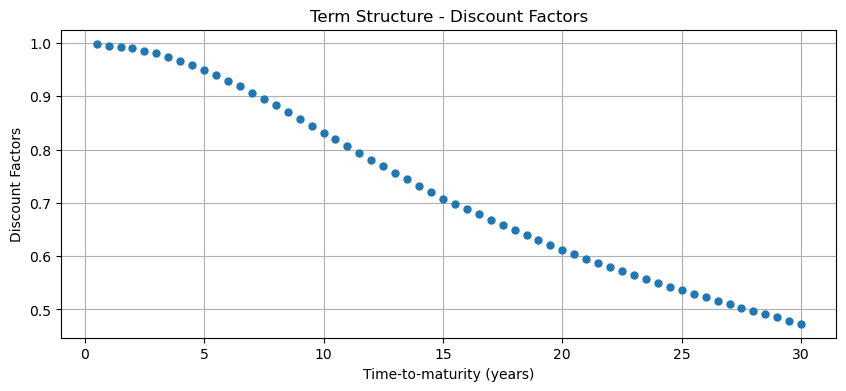

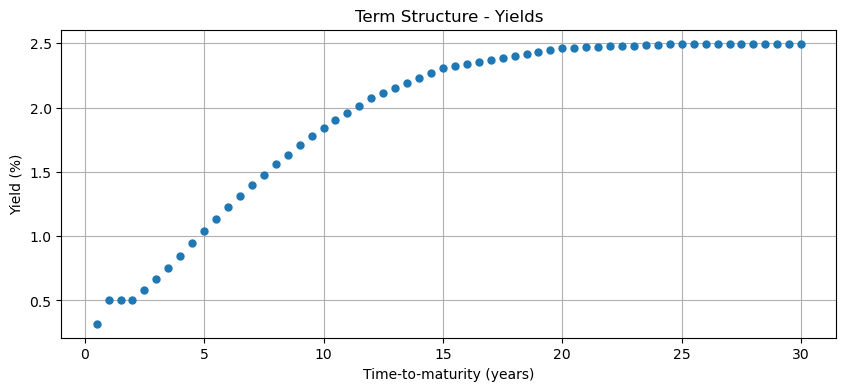

In [17]:
# Graphical representation of the term structure
# Plot 1: Term Structure of Discount Factors
plt.figure(figsize=(10, 4))
plt.plot(k, v, 'o', markersize=5)
plt.title('Term Structure - Discount Factors')
plt.xlabel('Time-to-maturity (years)')
plt.ylabel('Discount Factors')
plt.grid()  # Add grid for better readability
plt.show()

# Functional aspect:
# This plot shows the discount factors for different maturities. The discount factor decreases as the time-to-maturity increases,
# reflecting the fact that the present value of a future payment declines over time.
# It provides a visual representation of how much a payment in the future is worth in today's terms.

# Plot 2: Term Structure of Yields
plt.figure(figsize=(10, 4))
plt.plot(k, y * 100, 'o', markersize=5)
plt.title('Term Structure - Yields')
plt.xlabel('Time-to-maturity (years)')
plt.ylabel('Yield (%)')
plt.grid()  # Add grid for better readability
plt.show()

# Functional aspect:
# This plot shows the yields (annualized interest rates) for different maturities.
# The curve represents the "yield curve," which is a key indicator in finance.
# It provides insights into the market's expectations about future interest rates and economic conditions.
# Typically, a normal yield curve is upward sloping, indicating higher yields for longer maturities,
# reflecting the higher risk or opportunity cost associated with long-term investments.


### 4. Nelson-Siegel model

In [22]:
# Calibration of the Nelson-Siegel model

# Define the Nelson-Siegel model function
def NelSieg(x, tau):
    """
    Nelson-Siegel model for term structure of interest rates.
    
    Parameters:
    x: array of model parameters [theta1, theta2, theta3, theta4]
    tau: array of time-to-maturity values
    
    Returns:
    yNS: Nelson-Siegel modeled yields
    """
    theta1 = x[0]  # Level factor (long-term interest rate)
    theta2 = x[1]  # Slope factor (short-term dynamics)
    theta3 = x[2]  # Curvature factor (hump in the yield curve)
    theta4 = x[3]  # Decay factor (controls the speed of transition)
    
    aux1 = np.exp(-theta4 * tau)  # Exponential decay term
    aux2 = (1 - aux1) / (theta4 * tau)  # Smoothing term
    yNS = theta1 + theta2 * aux2 + theta3 * (aux2 - aux1)  # Nelson-Siegel equation
    
    return yNS

# Define the objective function to minimize
def objFunc(x, R, n, k):
    """
    Objective function for Nelson-Siegel calibration.
    
    Parameters:
    x: array of model parameters [theta1, theta2, theta3, theta4]
    R: observed yields
    n: number of observations
    k: time-to-maturity values
    
    Returns:
    ssr: sum of squared residuals (difference between observed and modeled yields)
    """
    ssr = 0  # Initialize the sum of squared residuals
    for i in range(n):  # Loop through all observations
        ssr += (NelSieg(x, k[i]) - R[i]) ** 2  # Calculate residual and square it
    return ssr

# Step 3: Initialize Nelson-Siegel parameters
x0 = np.array([0.5, 0.5, 0.5, 0.5])  # Initial guesses for parameters

# Step 4: Perform the optimization to calibrate the model
res = minimize(objFunc, x0, args=(y, n, k), method='BFGS', options={'gtol': 1e-8, 'disp': False})

# Extract the calibrated parameters
xNS = res.x


In [23]:
print("Calibrated Nelson-Siegel parameters:")
print("Theta1:", xNS[0])
print("Theta2:", xNS[1])
print("Theta3:", xNS[2])
print("Theta4:", xNS[3])

Calibrated Nelson-Siegel parameters:
Theta1: 0.029892789073844135
Theta2: -0.024147647093555984
Theta3: -0.038088686110825554
Theta4: 0.5344671491860957


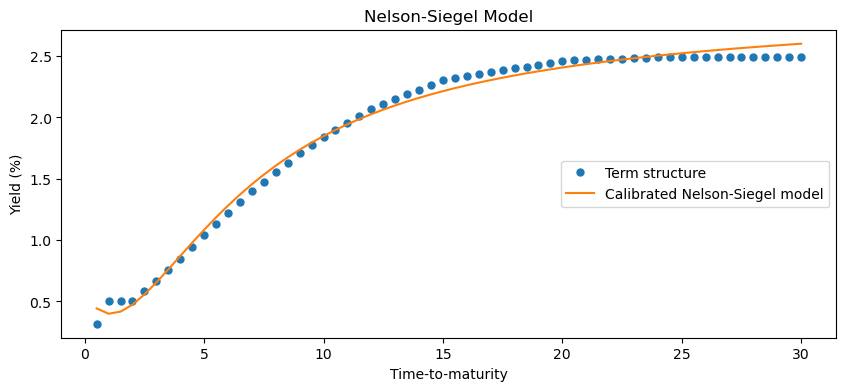

In [24]:
# Plot calibrated Nelson-Siegel term structure

plt.subplots(figsize=(10,4))
plt.plot(k,y*100,'o',markersize=5,label='Term structure')
plt.plot(k,NelSieg(xNS,k)*100,'-',markersize=10,label='Calibrated Nelson-Siegel model')
plt.title('Nelson-Siegel Model')
plt.ylabel('Yield (%)')
plt.xlabel('Time-to-maturity')
plt.legend(loc='right')
plt.show()

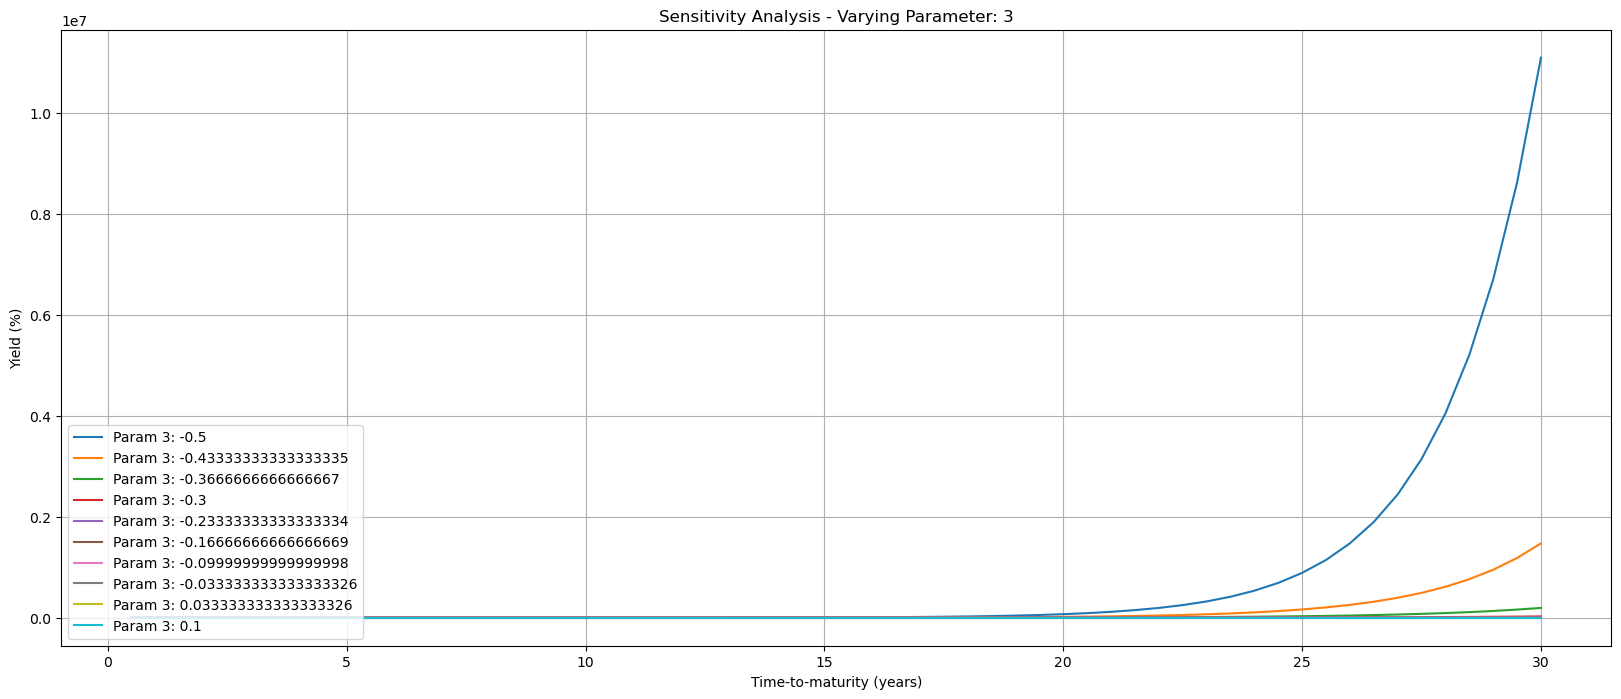

In [25]:
# Nelson-Siegel sensitivity analysis 

# Reset parameters to the calibrated values
xNS_ = xNS.copy()

# Select the parameter to vary for sensitivity analysis:
# 0: theta1 (Level Factor) - Shifts the entire curve up or down.
# 1: theta2 (Slope Factor) - Changes the slope, affecting short-term yields.
# 2: theta3 (Curvature Factor) - Adds a "hump" in the mid-term section.
# 3: theta4 (Decay Factor) - Adjusts the speed of transition between short and long-term yields.
param_to_vary = 3  # Change this to select which parameter to vary


# Create a range of values for the selected parameter
theta_space = np.linspace(-0.5, 0.1, 10)  # 10 values from -0.5 to 0.5

# Perform the sensitivity analysis
plt.figure(figsize=(20, 8))  # Create a larger figure for better visualization
for i in theta_space:
    xNS_[param_to_vary] = i  # Vary the selected parameter
    
    # Plot the Nelson-Siegel yield curve for the current parameter value
    plt.plot(k, NelSieg(xNS_, k) * 100, '-', markersize=10, label=f"Param {param_to_vary}: {i}")
    plt.legend(loc='lower left')  # Add a legend to identify the parameter variations

# Add title and display the plot
plt.title(f"Sensitivity Analysis - Varying Parameter: {param_to_vary}")
plt.xlabel("Time-to-maturity (years)")
plt.ylabel("Yield (%)")
plt.grid()  # Add grid for better readability
plt.show()


### 5. Svensson model

In [26]:
# Calibration of the Svensson model

def Sven(x, tau):
    """
    Svensson model for term structure of interest rates.
    
    Parameters:
    x: array of model parameters [theta1, theta2, theta3, theta4, theta5, theta6]
    tau: array of time-to-maturity values
    
    Returns:
    ySv: Svensson modeled yields
    """
    # Model parameters
    theta1 = x[0]  # Level factor (long-term interest rate)
    theta2 = x[1]  # Slope factor (short-term dynamics)
    theta3 = x[2]  # First curvature factor (hump in the mid-term section)
    theta4 = x[3]  # Second curvature factor (secondary hump)
    theta5 = x[4]  # Decay factor for first curvature term
    theta6 = x[5]  # Decay factor for second curvature term
    
    # Compute auxiliary terms
    aux1 = np.exp(-theta5 * tau)  # Exponential decay for first curvature term
    aux2 = (1 - aux1) / (theta5 * tau)  # Smoothing term for first curvature term
    aux3 = np.exp(-theta6 * tau)  # Exponential decay for second curvature term
    aux4 = (1 - aux3) / (theta6 * tau)  # Smoothing term for second curvature term
    
    # Svensson yield curve equation
    ySv = theta1 + theta2 * aux2 + theta3 * (aux2 - aux1) + theta4 * (aux4 - aux3)
    
    return ySv

def objFunc(x, y, n, k):
    """
    Objective function for Svensson model calibration.
    
    Parameters:
    x: array of model parameters [theta1, theta2, theta3, theta4, theta5, theta6]
    R: observed yields
    n: number of observations
    k: time-to-maturity values
    
    Returns:
    ssr: sum of squared residuals (difference between observed and modeled yields)
    """
    ssr = 0  # Initialize sum of squared residuals
    for i in range(n):  # Loop through all observations
        ssr += (Sven(x, k[i]) - y[i]) ** 2  # Calculate residual and square it
    return ssr


In [27]:
x0 = np.array([0.5,0.5,0.5,0.5,0.5,0.5])       
res = minimize(objFunc, x0, args=(y,n,k), method='BFGS', options={'gtol': 1e-8, 'disp': False})
xSv = res.x

In [28]:
print("Calibrated Svensson parameters:")
print("Theta1:", xSv[0])
print("Theta2:", xSv[1])
print("Theta3:", xSv[2])
print("Theta4:", xSv[3])
print("Theta5:", xSv[4])
print("Theta6:", xSv[5])

Calibrated Svensson parameters:
Theta1: 0.029556523761834364
Theta2: -0.03120598420763685
Theta3: 2.9279966176001633
Theta4: -2.960523948984339
Theta5: 0.9080021314751463
Theta6: 0.8971853804463452


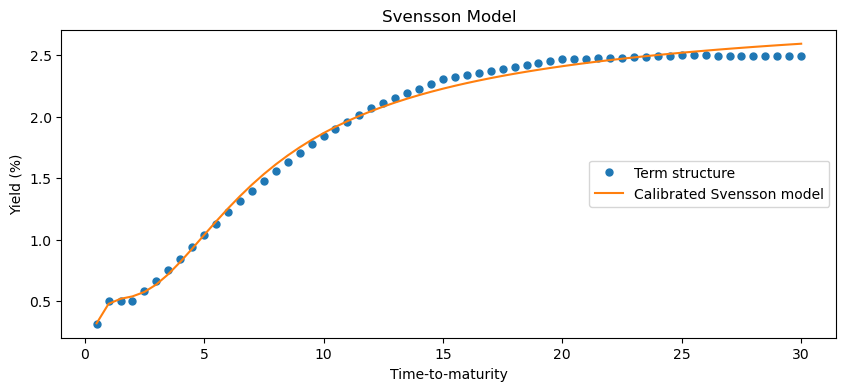

In [29]:
# Plot calibrated Svensson term structure

plt.subplots(figsize=(10,4))
plt.plot(k,y*100,'o',markersize=5,label='Term structure')
plt.plot(k,Sven(xSv,k)*100,'-',markersize=10,label='Calibrated Svensson model')
plt.title('Svensson Model')
plt.ylabel('Yield (%)')
plt.xlabel('Time-to-maturity')
plt.legend(loc='right')
plt.show()

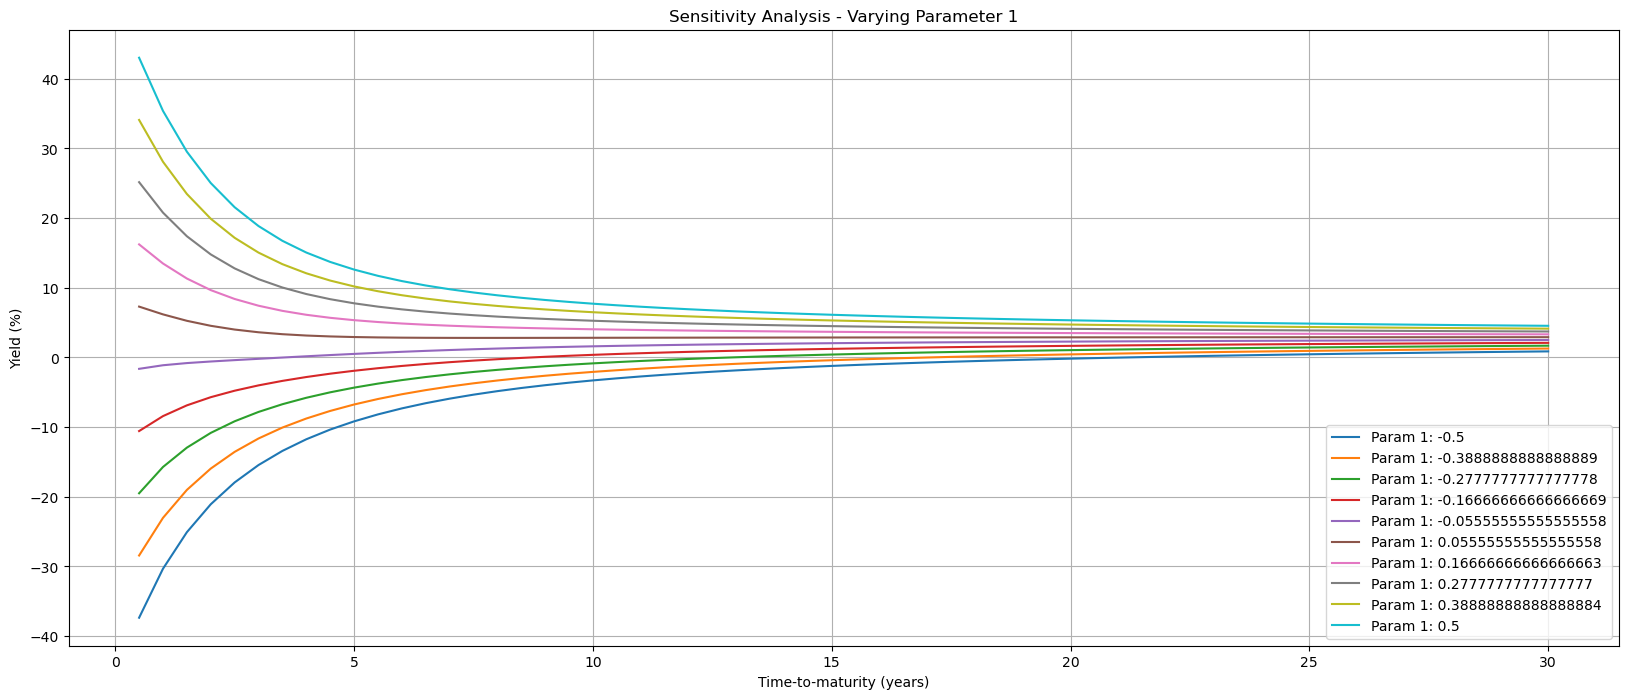

In [30]:
# Svensson sensitivity analysis

# Reset parameters to calibrated values
xSv_ = xSv.copy()

# Select the parameter to vary for sensitivity analysis:
# 0: theta1 (Level Factor) - Shifts the entire curve up or down.
# 1: theta2 (Slope Factor) - Changes the slope, affecting short-term yields.
# 2: theta3 (First Curvature Factor) - Adds a "hump" in the mid-term section.
# 3: theta4 (Second Curvature Factor) - Adds a second hump to the curve.
# 4: theta5 (Decay Factor 1) - Adjusts the position and speed of the first hump's decay.
# 5: theta6 (Decay Factor 2) - Adjusts the position and speed of the second hump's decay.
param_to_vary = 1  # Change this to select which parameter to vary

# Create a range of values for the selected parameter
theta_space = np.linspace(-0.5, 0.5, 10)  # 10 values from -0.5 to 0.5

# Perform the sensitivity analysis
plt.figure(figsize=(20, 8))  # Create a larger figure for better visualization
for i in theta_space:
    xSv_[param_to_vary] = i  # Vary the selected parameter
    
    # Plot the Svensson yield curve for the current parameter value
    plt.plot(k, Sven(xSv_, k) * 100, '-', markersize=10, label=f"Param {param_to_vary}: {i}")
    plt.legend(loc='lower right')  # Add a legend to identify the parameter variations

# Add title and display the plot
plt.title(f"Sensitivity Analysis - Varying Parameter {param_to_vary}")
plt.xlabel("Time-to-maturity (years)")
plt.ylabel("Yield (%)")
plt.grid()  # Add grid for better readability
plt.show()


### 6. Pricing of coupon bond using the calibrated Nelson-Siegel model and Svensson model

In [31]:
# Bond characteristics
N = 100                   # Face value (nominal value of the bond, in units of currency)
c = 2                     # Coupon payment (per payment period, in units of currency)
T = 10                    # Maturity of the bond (in years)
d = 0.5                   # Frequency of coupon payments (in fraction of a year, here semi-annual)
tau = np.arange(d, T + d, d)  # Times of coupon payments (0.5, 1.0, ..., T)

# Compute discount factors using the Nelson-Siegel and Svensson models
dfNS = np.exp(-tau * NelSieg(xNS, tau))  # Discount factors from Nelson-Siegel model
dfSv = np.exp(-tau * Sven(xSv, tau))    # Discount factors from Svensson model

# Compute the bond price as the sum of discounted cash flows
# Pricing formula:
# Bond price = Sum of discounted coupon payments + Discounted face value
# p = c * d * Sum(df) + N * df[-1]
# Where:
# - c * d is the coupon payment for each period.
# - Sum(df) discounts all the coupon payments up to maturity.
# - N * df[-1] discounts the face value at the final period.

pNS = c * d * np.sum(dfNS) + N * dfNS[-1]  # Bond price using Nelson-Siegel discount factors
pSv = c * d * np.sum(dfSv) + N * dfSv[-1]  # Bond price using Svensson discount factors

# Print the bond prices
print('Price of coupon bond is:')
print("Nelson-Siegel price:", pNS)
print("Svensson price:", pSv)

# Interpretation of prices:
# The bond price reflects the present value of all future cash flows (coupons + face value),
# discounted using the interest rates derived from the yield curve models.
# - If the Nelson-Siegel and Svensson prices differ, it may indicate differences in how the models 
#   estimate the shape of the yield curve and the corresponding discount factors.
# - A higher bond price indicates lower discount rates, suggesting a lower overall yield.
# - A lower bond price implies higher discount rates, reflecting a higher yield demanded by investors.


Price of coupon bond is:
Nelson-Siegel price: 101.75928674906623
Svensson price: 101.62451645560049
